<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/geodfprepro/blob/main/GeoDF_Operations.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Basic spatial operations in  Geo Dataframes

We will review some important formatting processes for geodataframes. As usual, let's do this: 

1. Create a repository named: **geodfprepro**.
2. Clone that repo to a local folder in your computer.
3. In that local folder in your computer, create a folder named **maps** and **data**.
4. Put the **brazilMaps_5641.gpkg**  file that contains the three maps prepared last class into the map folder.
5. Download the shapefile of "Brazil - Subnational Administrative Boundaries" from [here](https://data.humdata.org/dataset/cod-ab-bra) and save it in the maps folder (you need to unzip the file).
6. Download a **CSV** file with information on the airports in Brazil from this [website](https://data.humdata.org/dataset/ourairports-bra), I will save it in my **data** folder:
7. Commit and push.

Let's read _Brazil_5641.gpkg_ from the GitHub link with the help of **geopandas**:

In [2]:
import os


import geopandas as gpd
from  fiona import listlayers

#maps
argentinaMaps='https://github.com/Romina300/simpleplot/raw/main/maps/argentina22171/argentinaMaps22171.gpkg'

#layers in maps
listlayers(argentinaMaps)

['country', 'cities', 'rivers']

Retrieving each map (layer):

In [3]:
argentina=gpd.read_file(argentinaMaps,layer='country')
argentina_cities=gpd.read_file(argentinaMaps,layer='cities')
argentina_rivers=gpd.read_file(argentinaMaps,layer='rivers')

We know they share the same CRS:

In [4]:
argentina.crs.to_epsg()==argentina_cities.crs.to_epsg()==argentina_rivers.crs.to_epsg()

True

We also remember that having the same CRS allows one plot with several layers of maps:

<Axes: >

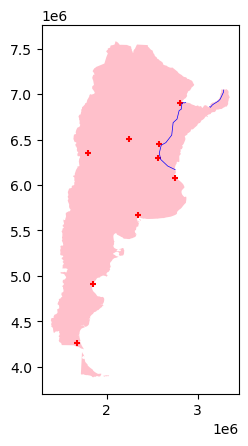

In [5]:
# plotting tinee que tner el mismo cr para que cada layer salga encima de otro ene la psoicion correcta
base = argentina.plot(facecolor="pink")
argentina_rivers.plot(edgecolor='blue', linewidth=0.5,ax=base)
argentina_cities.plot(marker='+', color='red', markersize=15,ax=base)

Now, let's see some important **spatial operations**:

1. [Formatting Projection](#1)
    * [Projecting Geoseries](#11) 
    * [Projecting Naive Geodata](#12)
    * [Projecting long/lat](#13)
    
2. [Combining GeoDF rows](#2)
    * [Dissolving](#21) 
    * [Unary union](#22)
      
4. [Creating Spatial Points](#3)
    * [Creating a convex hull](#31)
5. [Checking Validity](#4)



<a class="anchor" id="11"></a>

## Formating Geoseries projections



You know **brazil_5641** is a multipolygon:

In [6]:
argentina

COUNTRY                                           geometry
0  Argentina  MULTIPOLYGON (((1588143.249 5963164.249, 15912...

Sometime, you just need the border (lines):

In [7]:
argentina.boundary #por eso es multistring porque estoy pidiendo que gurade el borde del poligono
#me da un valor es como un dao el excel, es como que me da un valor dame la media y me da 3.5
#son diefentes estrcuturas de datos y por ello aplicaremos cierto tipo de funciones dependiedno de la estrcutura

0    MULTILINESTRING ((1588143.249 5963164.249, 159...
dtype: geometry

<Axes: >

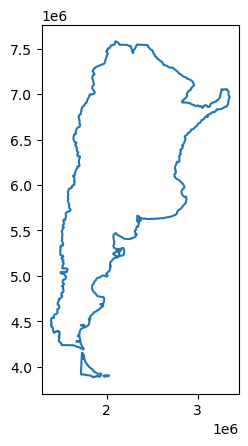

In [8]:
# This is just the borderline
argentina.boundary.plot()

Always check the data type:

In [9]:
# does 'boundary' return a GDF?
type(argentina.boundary)

geopandas.geoseries.GeoSeries

**Some operations** in geopandas **require GDF or GS**. If you need a GDF instead of a GS:

In [10]:
# converting into GDF
argentina.boundary.to_frame() #aqui lo he convertido en una tabla geodataframe
#esto es un gdf a partir de una geoseries
#le puedo decri a pyhton datos cual es la columna que tiene datos geometricos indepedneitemente de su nombre 'geometrías'
#por si acaso la geometria es 'geometrías'
#me asegruo de decirle cual es la geometria

0
0  MULTILINESTRING ((1588143.249 5963164.249, 159...

Notice **you get a very simple GDF**, and you may want to add some information:

In [11]:
# conversion
argentina_border=argentina.boundary.to_frame() 

# new column (optional)
argentina_border['name']='Argentina' 

# renaming the geometry column
argentina_border.rename(columns={0:'geometry'},inplace=True) 

#setting the geometry (the name is not enough)
argentina_border = argentina_border.set_geometry("geometry")

# verifying:
argentina_border.crs

<Projected CRS: EPSG:22171>
Name: POSGAR 98 / Argentina 1
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Argentina - west of 70°30'W.
- bounds: (-73.59, -52.0, -70.5, -36.16)
Coordinate Operation:
- name: Argentina zone 1
- method: Transverse Mercator
Datum: Posiciones Geodesicas Argentinas 1998
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

You see you _multistring_:

In [12]:
argentina_border #en la tarea tine que parecere tal cual asi geometry name y multistring

geometry       name
0  MULTILINESTRING ((1588143.249 5963164.249, 159...  Argentina

You can **add this GDF as a layer**:

### Exercise 1

<div class="alert-success"> 
    
1. Check if your country is a polygon or multipolygon.
    
2. Recover just the boundaries of that country.
    
3. Turn the boundary into a GDF.
</div>

<a class="anchor" id="12"></a>

## Lacking CRS information

Reprojecting seems a simple process, but you might find some interesting cases. Let's **read the maps on _states_ and _municipalities_**: y ambos son poligonos 

In [13]:
argentina_states=gpd.read_file(os.path.join("maps","arg_adm_unhcr2017_SHP","arg_admbnda_adm1_unhcr2017.shp"))
argentina_municipalities=gpd.read_file(os.path.join("maps","arg_adm_unhcr2017_SHP","arg_admbnda_adm2_unhcr2017.shp"))

Notice this:

In [14]:
argentina_states.crs, argentina_municipalities.crs

(<Projected CRS: EPSG:3857>
 Name: WGS 84 / Pseudo-Mercator
 Axis Info [cartesian]:
 - X[east]: Easting (metre)
 - Y[north]: Northing (metre)
 Area of Use:
 - name: World between 85.06°S and 85.06°N.
 - bounds: (-180.0, -85.06, 180.0, 85.06)
 Coordinate Operation:
 - name: Popular Visualisation Pseudo-Mercator
 - method: Popular Visualisation Pseudo Mercator
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

They do not have crs information, however they can be plotted:

<Axes: >

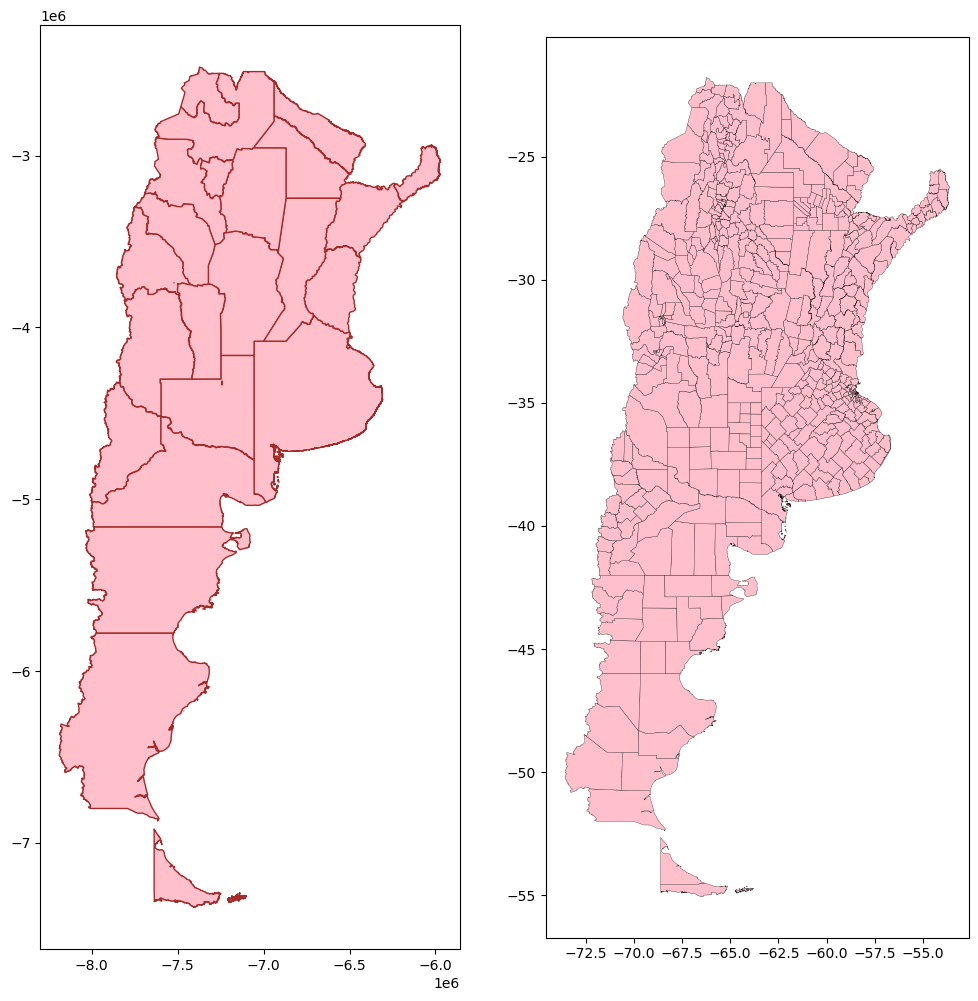

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

argentina_states.plot(ax=ax1, facecolor='pink', edgecolor='brown')
argentina_municipalities.plot(ax=ax2, facecolor='pink', edgecolor='black',linewidth=0.2)


Since we are using the crs 5641 for Brazil, the **initial strategy** could be **to set the CRS with the right projection** :

In [16]:
argentina_states.to_crs(22171)

ADM0_ES ADM0_PCODE                 ADM1_ES ADM1_PCODE  \
0   Argentina         AR            Buenos Aires      AR006   
1   Argentina         AR               Catamarca      AR010   
2   Argentina         AR                   Chaco      AR022   
3   Argentina         AR                  Chubut      AR026   
4   Argentina         AR  Ciudad de Buenos Aires      AR002   
5   Argentina         AR                 Córdoba      AR014   
6   Argentina         AR              Corrientes      AR018   
7   Argentina         AR              Entre Ríos      AR030   
8   Argentina         AR                 Formosa      AR034   
9   Argentina         AR                   Jujuy      AR038   
10  Argentina         AR                La Pampa      AR042   
11  Argentina         AR                La Rioja      AR046   
12  Argentina         AR                 Mendoza      AR050   
13  Argentina         AR                Misiones      AR054   
14  Argentina         AR                 Neuquén      AR058   
15  Argentina         AR               Río negro      AR062   
16  Argentina         AR                   Salta      AR066   
17  Argentina         AR                San Juan      AR070   
18  Argentina         AR                San Luis      AR074   
19  Argentina         AR              Santa Cruz      AR078   
20  Argentina         AR                Santa Fe      AR082   
21  Argentina         AR     Santiago del Estero      AR086   
22  Argentina         AR        Tierra del Fuego      AR094   
23  Argentina         AR                 Tucumán      AR090   

                                             geometry  
0   MULTIPOLYGON Z (((2335919.444 5475450.748 0.00...  
1   POLYGON Z ((1906189.076 7204695.456 0.000, 191...  
2   POLYGON Z ((2494292.791 7296258.081 0.000, 249...  
3   MULTIPOLYGON Z (((1916196.919 4975824.860 0.00...  
4   POLYGON Z ((2747577.276 6094399.410 0.000, 274...  
5   POLYGON Z ((2288373.932 6695803.079 0.000, 228...  
6   MULTIPOLYGON Z (((3004612.053 6855238.635 0.00...  
7   POLYGON Z ((2798505.825 6586816.825 0.000, 279...  
8   POLYGON Z ((2497424.367 7484757.793 0.000, 249...  
9   POLYGON Z ((2098377.586 7581146.835 0.000, 210...  
10  POLYGON Z ((2188602.680 6101304.588 0.000, 219...  
11  POLYGON Z ((1842905.218 6918621.830 0.000, 184...  
12  POLYGON Z ((1771643.879 6456186.096 0.000, 177...  
13  MULTIPOLYGON Z (((3095005.586 6872963.019 0.00...  
14  POLYGON Z ((1644565.805 5998409.218 0.000, 164...  
15  MULTIPOLYGON Z (((2110903.688 5460168.313 0.00...  
16  POLYGON Z ((2451820.395 7539541.582 0.000, 245...  
17  POLYGON Z ((1734160.435 6855329.798 0.000, 173...  
18  POLYGON Z ((1968211.713 6465395.769 0.000, 196...  
19  MULTIPOLYGON Z (((1681041.738 4336736.817 0.00...  
20  POLYGON Z ((2663631.362 6846895.383 0.000, 270...  
21  POLYGON Z ((2502694.378 7125547.160 0.000, 250...  
22  MULTIPOLYGON Z (((1848191.934 3884066.663 0.00...  
23  POLYGON Z ((2165451.970 7101554.297 0.000, 216...

Python says **_"Please set a crs on the object first"_**. This would mean **to know the actual projection, of the geometry**:

In [17]:
argentina_states.geometry.head()

0    MULTIPOLYGON Z (((-6918884.037 -4931769.351 0....
1    POLYGON Z ((-7566501.154 -2903626.584 0.000, -...
2    POLYGON Z ((-6929548.312 -2770568.731 0.000, -...
3    MULTIPOLYGON Z (((-7424844.932 -5660565.812 0....
4    POLYGON Z ((-6507173.600 -4100891.637 0.000, -...
Name: geometry, dtype: geometry

**From the plots above and the previous rows**, we conclude the **maps are unprojected map**; then:

In [18]:
argentina_states.crs = "EPSG:4326"
argentina_municipalities.crs = "EPSG:4326"

Now, we can reproject:

In [19]:
argentina_states=argentina_states.to_crs(22171)
argentina_municipalities=argentina_municipalities.to_crs(22171)

### Exercise 2

<div class="alert-success">

1. Look for sub administrative divisions of your country obligatorio, pero si tienen los crs ya no hay nada mas que hacer
    es opcional encontrar un pais que no lo tenga y ponerle nombre =ESPG=5346
2. Check all the CRSs of those divisions
3. If you find one CRS is missing, fill the CRS with the right projection.
</div>

<a class="anchor" id="13"></a>

## Projecting Lat/Lon Points

You will get Lines and Polygons as maps for sure, but that may not be the case with points. These points came as a CSV file:

In [20]:
import pandas as pd 
infomuseos=pd.read_csv(os.path.join("data","museos_datosabiertos.csv"))

# see

infomuseos
#EL QUE TENGA CORRDENADAS NO LO HAVE UN OBEJTO ESPACIAL
#Es importante porque en algun momneto mr van a dar coordenadas y tengo que saber como convetir 

Cod_Loc  IdProvincia  IdDepartamento  Observaciones  \
0      6588100            6            6588            NaN   
1      6077010            6            6077            NaN   
2      6035010            6            6035            NaN   
3      6035010            6            6035            NaN   
4      6049020            6            6049            NaN   
...        ...          ...             ...            ...   
1177  90098040           90           90098            NaN   
1178  90105080           90           90105            NaN   
1179  90105080           90           90105            NaN   
1180  90105070           90           90105            NaN   
1181  90098040           90           90098            NaN   

                               categoria subcategoria     provincia  \
0     Espacios de Exhibición Patrimonial       Museos  Buenos Aires   
1     Espacios de Exhibición Patrimonial       Museos  Buenos Aires   
2     Espacios de Exhibición Patrimonial       Museos  Buenos Aires   
3     Espacios de Exhibición Patrimonial       Museos  Buenos Aires   
4     Espacios de Exhibición Patrimonial       Museos  Buenos Aires   
...                                  ...          ...           ...   
1177  Espacios de Exhibición Patrimonial       Museos       Tucumán   
1178  Espacios de Exhibición Patrimonial       Museos       Tucumán   
1179  Espacios de Exhibición Patrimonial       Museos       Tucumán   
1180  Espacios de Exhibición Patrimonial       Museos       Tucumán   
1181  Espacios de Exhibición Patrimonial       Museos       Tucumán   

              localidad                                             nombre  \
0            9 de Julio     Archivo Y Museo Histórico Gral. Julio De Vedia   
1             Arrecifes             Museo Y Archivo Histórico De Arrecifes   
2            Avellaneda    Museo Histórico-Sacro  Hno. Rogelio Scortegagna   
3            Avellaneda   Museo Municipal De Artes Plásticas De Avellaneda   
4                  Azul  Museo Etnográfico Y Archivo Histórico Enrique ...   
...                 ...                                                ...   
1177     Tafí del Valle  Museo Histórico Y Arqueológico Jesuítico La Banda   
1178         Tafí Viejo                 Mac-Museo Arqueológico El Cadillal   
1179         Tafí Viejo    Museo Ferroviario De Los Talleres De Tafí Viejo   
1180  Villa El Cadillal             Museo Arqueológico Dr. Ernesto Padilla   
1181     Tafí del Valle  Asentamientos De Menhires En Las Áreas Arqueol...   

                             direccion  ...                        Mail  \
0                        Libertad 1191  ...  archivoymuseo@yahoo.com.ar   
1               Gerardo Risso y España  ...  museoarrecifes@hotmail.com   
2     Calle 11 (Av. San Martín) Nº 830  ...                         NaN   
3              Sarmiento 101, 1 º Piso  ...                         NaN   
4               Bartolomé J. Ronco 654  ...         museoazul@yahoo.com   
...                                ...  ...                         ...   
1177                      La Banda S/N  ...                         NaN   
1178      Centro Principal el Cadillal  ...                         NaN   
1179   Avda. Pte. Roque Sáenz Peña 234  ...                         NaN   
1180               Ernesto Padilla S/N  ...                         NaN   
1181                               NaN  ...                         NaN   

                                 Web    Latitud   Longitud  \
0              www.portaldel9.com.ar -35.441762 -60.887598   
1                                NaN -34.066970 -60.102555   
2                                NaN -29.118024 -59.654543   
3                                NaN -34.662110 -58.363270   
4                                NaN -36.781824 -59.858636   
...                              ...        ...        ...   
1177                             NaN -26.852880 -65.712622   
1178                             NaN -26.683331 -65.266670   
1179         

This needs some cleaning, as the first row has column names, and some columns are not needed:

In [22]:
# bye first row 
infomuseos.drop(index=0,inplace=True)
infomuseos.reset_index(drop=True, inplace=True)

# keep the  columns needed
keep=['nombre','jurisdiccion','Latitud', 'Longitud','provincia','localidad']
infomuseos=infomuseos.loc[:,keep]
infomuseos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nombre        1180 non-null   object 
 1   jurisdiccion  1083 non-null   object 
 2   Latitud       1180 non-null   float64
 3   Longitud      1180 non-null   float64
 4   provincia     1180 non-null   object 
 5   localidad     1180 non-null   object 
dtypes: float64(2), object(4)
memory usage: 55.4+ KB


Some formatting is needed, because numeric data columns are not the right type:

In [169]:
#numericCols=['Latitud', 'Longitud']
#infoairports[numericCols]=infoairports.loc[:,numericCols].apply(lambda x:pd.to_numeric(x))

# now 
#infoairports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           941 non-null    object 
 1   type           941 non-null    object 
 2   latitude_deg   941 non-null    float64
 3   longitude_deg  941 non-null    float64
 4   elevation_ft   907 non-null    float64
 5   region_name    941 non-null    object 
 6   municipality   926 non-null    object 
dtypes: float64(3), object(4)
memory usage: 51.6+ KB


<Axes: xlabel='Longitud', ylabel='Latitud'>

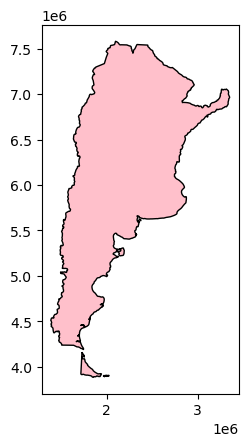

In [23]:
# let's plot

mapabase = argentina.plot(color='pink', edgecolor='black') #unprojected

infomuseos.plot.scatter(x = 'Longitud', y = 'Latitud',ax=base)

We get it wrong because coordinates of both **do not match**. Let's try this:

1. Create a **GeoDataFrame with the points, keeping them unprojected**:

In [110]:
museos=gpd.GeoDataFrame(data=infomuseos.copy(),
                 geometry=gpd.points_from_xy(infomuseos.Longitud,
                                             infomuseos.Latitud), 
                 crs=4326)# the coordinates were in degrees - unprojected
#simepre q alg diga longitud latitud es q est a no protyecatdi
#e 5341 es la proyeccion del mapa de brasil


In [113]:
museos

nombre jurisdiccion  \
0       Museo Histórico-Sacro  Hno. Rogelio Scortegagna    Municipal   
1      Museo Municipal De Artes Plásticas De Avellaneda    Municipal   
2     Museo Etnográfico Y Archivo Histórico Enrique ...      Privada   
3                                 Museo De Bellas Artes    Municipal   
4                                     Museo De Ciencias    Municipal   
...                                                 ...          ...   
1175  Museo Histórico Y Arqueológico Jesuítico La Banda          NaN   
1176                 Mac-Museo Arqueológico El Cadillal   Provincial   
1177    Museo Ferroviario De Los Talleres De Tafí Viejo      Privada   
1178             Museo Arqueológico Dr. Ernesto Padilla   Provincial   
1179  Asentamientos De Menhires En Las Áreas Arqueol...   Provincial   

        Latitud   Longitud     provincia          localidad  \
0    -29.118024 -59.654543  Buenos Aires         Avellaneda   
1    -34.662110 -58.363270  Buenos Aires         Avellaneda   
2    -36.781824 -59.858636  Buenos Aires               Azul   
3    -38.713100 -62.262200  Buenos Aires       Bahía Blanca   
4    -38.692800 -62.308700  Buenos Aires       Bahía Blanca   
...         ...        ...           ...                ...   
1175 -26.852880 -65.712622       Tucumán     Tafí del Valle   
1176 -26.683331 -65.266670       Tucumán         Tafí Viejo   
1177 -26.740733 -65.263231       Tucumán         Tafí Viejo   
1178 -21.937642 -66.052043       Tucumán  Villa El Cadillal   
1179 -26.852880 -65.712622       Tucumán     Tafí del Valle   

                             geometry  
0     POINT (2706482.482 6715733.027)  
1     POINT (2754116.384 6079013.591)  
2     POINT (2586083.642 5860164.646)  
3     POINT (2347830.608 5670007.583)  
4     POINT (2344015.186 5672702.400)  
...                               ...  
1175  POINT (2125610.972 7015090.725)  
1176  POINT (2171105.180 7031660.877)  
1177  POINT (2171109.764 7025256.163)  
1178  POINT (2115269.005 7563109.326)  
1179  POINT (2125610.972 7015090.725)  

[1180 rows x 7 columns]

museos

2. Reproject the GeoDataFrame:

In [111]:
museos=museos.to_crs(22171)

Does it look better?

<Axes: >

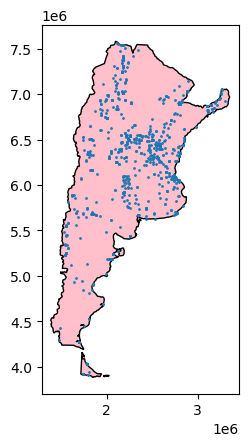

In [114]:
# let's plot

base = argentina.plot(color='pink', edgecolor='black')
museos.plot(ax=base,markersize=1)

# Now we have a **spatial points**: wiii

In [29]:
#remember:
type(museos), type(infomuseos)

(geopandas.geodataframe.GeoDataFrame, pandas.core.frame.DataFrame)

Remember you have type of airports:

In [32]:
museos['jurisdiccion'].value_counts() # this will not work: airports.type.value_counts()
#recomendacon es no ponerle type como nmbre de columna porque de por si type es una funcion q te indica el tipo de dato

jurisdiccion
Municipal                                                                           429
Privada                                                                             255
Provincial                                                                          167
Nacional                                                                            143
s/d                                                                                  32
Comunal                                                                              24
Privado                                                                              12
Mixta                                                                                 5
Provincial y Municipal                                                                3
Gobierno de la Ciudad                                                                 3
Mixta: Orden Franciscana y Municipalidad de San Fernando del Valle de Catamarca.      2
Mixta: Municipal / 

We may use that in the future. For now, just give the **type** column a different name.

In [74]:
#airports.rename(columns={'type':'kind'},inplace=True)

Let's play with this:

In [43]:
from folium import LayerControl


m = museos[museos.jurisdiccion=='Municipal'].explore(color="red",name="Municipal",show=False)
m = museos[museos.jurisdiccion=='Privada'].explore(m=m, color="blue",name="Privada",show=False)
m = museos[museos.jurisdiccion=='Provincial'].explore(m=m, color="black",name="Provincial",show=True)
m = museos[museos.jurisdiccion=='Nacional'].explore(m=m, color="green",name="Nacional",show=False)
m = museos[museos.jurisdiccion=='s/d'].explore(m=m, color="pink",name="s/d",show=False)
m = museos[museos.jurisdiccion=='Comunal'].explore(m=m, color="orange",name="Comunal",show=False)
m = museos[museos.jurisdiccion=='Privado'].explore(color="red",name="Privado",show=False)
m = museos[museos.jurisdiccion=='Mixta'].explore(m=m, color="blue",name="Mixta",show=False)
m = museos[museos.jurisdiccion=='Provincial y Municipal'].explore(m=m, color="black",name="Provincial_y_Municipal",show=False)
m = museos[museos.jurisdiccion=='Gobierno de la Ciudad'].explore(m=m, color="green",name="Gobierno_de_la_Ciudad",show=False)
#m = museos[museos.jurisdiccion=='Mixta: Orden Franciscana y Municipalidad de San Fernando del Valle de Catamarca'].explore(m=m, color="pink",name="Orden_Franciscana_y_Municipalidad_de_San_Fernando_del_Valle_de_Catamarca",show=False)
m = museos[museos.jurisdiccion=='Mixta: Municipal / Privada'].explore(m=m, color="orange",name="Municipal_Privada",show=False)
m = museos[museos.jurisdiccion=='Mixto Provincial y Privado'].explore(m=m, color="blue",name="Provincial_Privado",show=False)
m = museos[museos.jurisdiccion=='Mixta-Privada/Municipal'].explore(m=m, color="black",name="Privada_Municipal",show=False)
m = museos[museos.jurisdiccion=='Mixta Provincial/Municipal'].explore(m=m, color="green",name="Provincial_Municipal",show=False)
m = museos[museos.jurisdiccion=='Mixta: Privada/Municipal'].explore(m=m, color="pink",name="Privada/Municipal",show=False)
m = museos[museos.jurisdiccion=='Mixta, Nacional y Municipal'].explore(m=m, color="orange",name="Nacional_Municipal",show=False)
#m = museos[museos.jurisdiccion=='Mixta: Municipal/Privada '].explore(m=m, color="pink",name="Municipal/Privada",show=False)
m = museos[museos.jurisdiccion=='Puerto'].explore(m=m, color="orange",name="Puerto",show=False)

LayerControl(collapsed=False).add_to(m) #optional

m
#lo q se nos ocurra q sean puntos, buscar un csv que diga COORDINATES, ej. colegios, hospitales, aeropuertos


### Exercise 3 
<div class="alert-success">

1. Look for some points in a CSV file about your country.
    
2. Turn those points into a spatial object.
    
3. Save the layer.
    
</div>

<a class="anchor" id="2"></a>

## Combing GeoDF rows

Let me **divide Brazil municipalities** using the **centroid of Brazil**:

In [46]:
centroArgentina=argentina.centroid# es una geoserie es un valor calculado
centroArgentina

0    POINT (2166251.918 6144387.372)
dtype: geometry

Notice:

In [47]:
type(centroArgentina), type(centroArgentina.x)

(geopandas.geoseries.GeoSeries, pandas.core.series.Series)

The previous values are complex structures, not simple values. Then:

In [48]:
type(centroArgentina.x[0]),type(centroArgentina.y[0])
#dependiendo de lo que me pide la funcion, si admite geoseries ponerle geoseries, avces puede funcionar con otro tipo de dato
#pero me puede mandar un warning y mejor ponerle su tipo de dato tla cual pide

(numpy.float64, numpy.float64)

Let me now subset using  **geopandas'  cx**, which does **subsetting by location**:

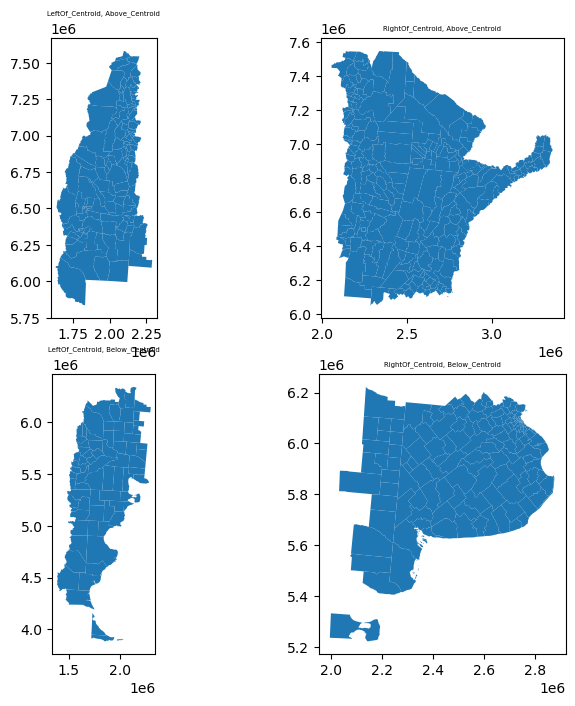

In [49]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=False, sharey=False,figsize=(8,8))

centroidX=centroArgentina.x[0]
centroidY=centroArgentina.y[0]

axs[0,0].set_title('LeftOf_Centroid, Above_Centroid',fontsize=5)
argentina_municipalities.cx[:centroidX,centroidY:].plot(ax=axs[0,0]) 

axs[0,1].set_title('RightOf_Centroid, Above_Centroid',fontsize=5)
argentina_municipalities.cx[centroidX:,centroidY:].plot(ax=axs[0,1]) 

axs[1,0].set_title('LeftOf_Centroid, Below_Centroid',fontsize=5)
argentina_municipalities.cx[:centroidX,:centroidY].plot(ax=axs[1,0]) 

axs[1,1].set_title('RightOf_Centroid, Below_Centroid',fontsize=5)
argentina_municipalities.cx[centroidX:,:centroidY].plot(ax=axs[1,1]) ;

In [50]:
#profesor dijo que se puede poner con ciudades o con minucipapldfaed

You can create a polygon with one of these:

In [51]:
#instead of:
argentina_municipalities.cx[:centroidX,centroidY:]#el cx es de geopandas solo lo entiende geopandas , pandas no
#el cx necesita un valor

ADM0_ES ADM0_PCODE    ADM1_ES ADM1_PCODE          ADM2_ES  \
0    Argentina         AR   La Rioja      AR046           Arauco   
7    Argentina         AR    Mendoza      AR050       Santa Rosa   
12   Argentina         AR  Catamarca      AR010      Santa María   
17   Argentina         AR   La Rioja      AR046    Independencia   
18   Argentina         AR   La Rioja      AR046   General Ocampo   
..         ...        ...        ...        ...              ...   
509  Argentina         AR   La Rioja      AR046         Famatina   
510  Argentina         AR    Tucumán      AR090      Yerba Buena   
516  Argentina         AR    Tucumán      AR090         La Cocha   
519  Argentina         AR   San Luis      AR074            Junín   
520  Argentina         AR    Tucumán      AR090  Juan B. Alberdi   

            ADM2_REF ADM2_PCODE  \
0             Arauco   AR046007   
7         Santa Rosa   AR050112   
12       Santa Maria   AR010091   
17     Independencia   AR046105   
18    General Ocampo   AR046084   
..               ...        ...   
509         Famatina   AR046049   
510      Yerba Buena   AR090119   
516         La Cocha   AR090049   
519            Junin   AR074049   
520  Juan B. Alberdi   AR090042   

                                              geometry  
0    POLYGON Z ((2035707.200 6832436.727 0.000, 203...  
7    POLYGON Z ((1899146.694 6291175.015 0.000, 189...  
12   POLYGON Z ((2081789.023 7097206.516 0.000, 208...  
17   POLYGON Z ((1996043.222 6669967.019 0.000, 199...  
18   POLYGON Z ((2072670.364 6583469.777 0.000, 207...  
..                                                 ...  
509  POLYGON Z ((1907352.885 6862646.497 0.000, 190...  
510  POLYGON Z ((2154811.333 7029885.745 0.000, 215...  
516  POLYGON Z ((2137720.175 6930143.625 0.000, 213...  
519  POLYGON Z ((2089223.690 6455533.587 0.000, 208...  
520  POLYGON Z ((2115126.424 6939897.785 0.000, 211...  

[126 rows x 8 columns]

<a class="anchor" id="21"></a>

### Dissolve

Let's use **dissolve**:

In [52]:
# dissolving
argentina_municipalities.cx[:centroidX,centroidY:].dissolve()

geometry    ADM0_ES ADM0_PCODE  \
0  POLYGON Z ((1837433.176 5990761.421 0.000, 183...  Argentina         AR   

    ADM1_ES ADM1_PCODE ADM2_ES ADM2_REF ADM2_PCODE  
0  La Rioja      AR046  Arauco   Arauco   AR046007

The 126 rows from the previous GDF are now one, Notice that some columns may be meaningless. And the result is:

In [53]:
type(argentina_municipalities.cx[:centroidX,centroidY:].dissolve())
#algunas funcoines devuelven geoseries, esta devuelve un dataframe

geopandas.geodataframe.GeoDataFrame

As a GeoDF we can plot:

<Axes: >

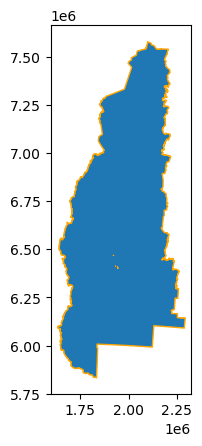

In [54]:
argentina_municipalities.cx[:centroidX,centroidY:].dissolve().plot(edgecolor='orange')

By default, dissolve combines **all into one**, but dissolving **also allows combining by other column**; for example:

<Axes: >

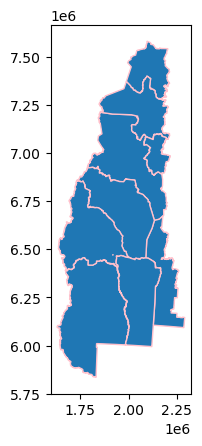

In [55]:
# the municipalities by state
argentina_municipalities.cx[:centroidX,centroidY:].dissolve(by='ADM1_ES').plot(edgecolor='pink')
#si no le idgo nada disucleve todo y si le digo disuelve por grupos junsta todas las geometrias 
#los ha juntado por estados

### Unary Union

This operation **is used to combine all the geometries in one GeoDF**:

In [56]:
argentina_municipalities.cx[:centroidX,centroidY:].unary_union

It looks like dissolve default behaviour, but:

In [57]:
type(argentina_municipalities.cx[:centroidX,centroidY:].unary_union)
#normalenete uno hace algo para combinarlo con otras cosas
#entnces para eso necesitamos usar estrufruas conocidas
#o sea puede ser que este mapa que me arrojo se vea bien, pero mejor converetilo a una estructura concocida
#el unary union es una geometria y calcula rapido te devuleve shaping

shapely.geometry.polygon.Polygon

The **result** is **not a GeoDF**. It **is a _shapely_ geometry**. You could **turn that into a GeoSeries**:

In [58]:
gpd.GeoDataFrame(index=[0],
                 crs=argentina_municipalities.crs,
                 geometry=[argentina_municipalities.cx[:centroidX,centroidY:].unary_union])
#lo pongo como una lista por si hay mas geometrias

geometry
0  POLYGON Z ((1837433.176 5990761.421 0.000, 183...

Notice that **_unary union_ erase all other columns**; it **only produces** the **geometry combined**. 

Let me **use the dissolve this time**:

In [59]:
# you create
Argentina_topLeft=argentina_municipalities.cx[:centroidX,centroidY:].dissolve()
# you get
Argentina_topLeft
#el disolve te devulve dataframe pero te agrag columnas q no sirven a vces 

geometry    ADM0_ES ADM0_PCODE  \
0  POLYGON Z ((1837433.176 5990761.421 0.000, 183...  Argentina         AR   

    ADM1_ES ADM1_PCODE ADM2_ES ADM2_REF ADM2_PCODE  
0  La Rioja      AR046  Arauco   Arauco   AR046007

Aside from the **ADM0_ES** and  **geometry column**, **the rest is meaningless**, then:

In [60]:
#por qué?

In [61]:
Argentina_topLeft['zone']='NW' # add column
Argentina_topLeft=Argentina_topLeft.loc[:,['ADM0_ES','zone','geometry']]   # keep some

# result
Argentina_topLeft

ADM0_ES zone                                           geometry
0  Argentina   NW  POLYGON Z ((1837433.176 5990761.421 0.000, 183...

We can **do the same with the other parts**:

In [62]:
Argentina_topRight=argentina_municipalities.cx[centroidX:,centroidY:].dissolve()
Argentina_bottomLeft=argentina_municipalities.cx[:centroidX,:centroidY].dissolve()
Argentina_bottomRight=argentina_municipalities.cx[centroidX:,:centroidY].dissolve()

Argentina_topRight['zone']='NE'
Argentina_topRight=Argentina_topRight.loc[:,['ADM0_ES','zone','geometry']] 

Argentina_bottomLeft['zone']='NE'
Argentina_bottomLeft=Argentina_bottomLeft.loc[:,['ADM0_ES','zone','geometry']] 

Argentina_bottomRight['zone']='NE'
Argentina_bottomRight=Argentina_bottomRight.loc[:,['ADM0_ES','zone','geometry']] 


Keep in mind that with **CX** you may **not get** a **perfect partition:**

In [63]:
argentina_municipalities

ADM0_ES ADM0_PCODE       ADM1_ES ADM1_PCODE        ADM2_ES  \
0    Argentina         AR      La Rioja      AR046         Arauco   
1    Argentina         AR  Buenos Aires      AR006   Tres Arroyos   
2    Argentina         AR         Jujuy      AR038      El Carmen   
3    Argentina         AR  Buenos Aires      AR006        Pinamar   
4    Argentina         AR  Buenos Aires      AR006  General Pinto   
..         ...        ...           ...        ...            ...   
521  Argentina         AR  Buenos Aires      AR006      San Pedro   
522  Argentina         AR         Salta      AR066          Iruya   
523  Argentina         AR         Jujuy      AR038  Santa Bárbara   
524  Argentina         AR  Buenos Aires      AR006       Suipacha   
525  Argentina         AR  Buenos Aires      AR006          Salto   

          ADM2_REF ADM2_PCODE  \
0           Arauco   AR046007   
1     Tres Arroyos   AR006833   
2        El Carmen   AR038014   
3          Pinamar   AR006644   
4    General Pinto   AR006351   
..             ...        ...   
521      San Pedro   AR006770   
522          Iruya   AR066070   
523  Santa Barbara   AR038070   
524       Suipacha   AR006784   
525          Salto   AR006714   

                                              geometry  
0    POLYGON Z ((2035707.200 6832436.727 0.000, 203...  
1    POLYGON Z ((2538302.326 5707868.076 0.000, 254...  
2    POLYGON Z ((2184906.173 7295226.281 0.000, 218...  
3    POLYGON Z ((2844051.406 5776077.259 0.000, 284...  
4    POLYGON Z ((2421316.725 6134973.446 0.000, 243...  
..                                                 ...  
521  POLYGON Z ((2633048.513 6217696.227 0.000, 263...  
522  POLYGON Z ((2245359.400 7485474.596 0.000, 224...  
523  POLYGON Z ((2302696.635 7378040.184 0.000, 230...  
524  POLYGON Z ((2630976.901 6107554.253 0.000, 263...  
525  POLYGON Z ((2583841.335 6176079.272 0.000, 258...  

[526 rows x 8 columns]

Calculemos la diferencia:

In [70]:
# tuple with count of rows
rowsCX=(argentina_municipalities.cx[:centroArgentina.x[0],centroArgentina.y[0]:].shape[0],\
        argentina_municipalities.cx[centroArgentina.x[0]:,centroArgentina.y[0]:].shape[0],\
        argentina_municipalities.cx[:centroArgentina.x[0],:centroArgentina.y[0]].shape[0],\
        argentina_municipalities.cx[centroArgentina.x[0]:,:centroArgentina.y[0]].shape[0])

sum(rowsCX)
#como hay cosas(municipalidades) q se repiten entonces al sumar salen menos 5753

593

In [71]:
# coincidences:
len(set(argentina_municipalities.cx[:centroArgentina.x[0],centroArgentina.y[0]:].ADM2_PCODE). \
intersection(set(argentina_municipalities.cx[centroArgentina.x[0]:,centroArgentina.y[0]:].ADM2_PCODE)). \
intersection(set(argentina_municipalities.cx[:centroArgentina.x[0],:centroArgentina.y[0]].ADM2_PCODE)). \
intersection(set(argentina_municipalities.cx[centroArgentina.x[0]:,:centroArgentina.y[0]].ADM2_PCODE)))

1

Adding up all the rows, we have more municipalities:

In [72]:
totalMuni=argentina_municipalities.shape[0]
totalMuni

526

In [73]:
sum(rowsCX)-totalMuni

67

There are some that are common:

<Axes: >

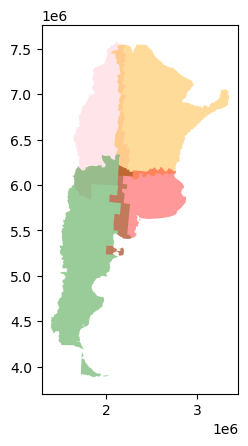

In [67]:
base=Argentina_topLeft.plot(facecolor='pink', alpha=0.4)
Argentina_topRight.plot(ax=base,facecolor='orange', alpha=0.4)
Argentina_bottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Argentina_bottomRight.plot(ax=base,facecolor='red', alpha=0.4)

### Exercise 4


<div class="alert-success"> 

1. Compute the centroid of your country.

2. Combine all the polygons to the north, and also all the polygons to the south; use unary union.

3. Detect the amount of duplicates after the combination.

4. Plot both maps so that duplicates appear.
    
</div>

<a class="anchor" id="31"></a>

## Creating the convex hull

Some times you may have the **need to create a polygon** that **serves as an envelope to a set of points**:

In [68]:
Argentina_museoTopLeft=museos[museos.jurisdiccion=='Municipal'].cx[:centroidX,centroidY:]
Argentina_museoTopRight=museos[museos.jurisdiccion=='Municipal'].cx[centroidX:,centroidY:]
Argentina_museoBottomLeft=museos[museos.jurisdiccion=='Municipal'].cx[:centroidX,:centroidY]
Argentina_museoBottomRight=museos[museos.jurisdiccion=='Municipal'].cx[centroidX:,:centroidY]

<Axes: >

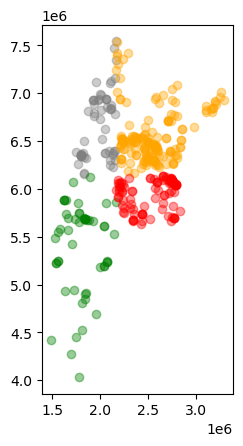

In [69]:
base=Argentina_museoTopLeft.plot(facecolor='grey', alpha=0.4)
Argentina_museoTopRight.plot(ax=base,facecolor='orange', alpha=0.4)
Argentina_museoBottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Argentina_museoBottomRight.plot(ax=base,facecolor='red', alpha=0.4)

Notice we have simple points:

In [74]:
Argentina_museoBottomLeft

nombre jurisdiccion  \
215                   Museo Tecnológico De La Localidad    Municipal   
221      Museo Regional Patagónico Prof. Antonio Garcés    Municipal   
226           Museo De Culturas Originarias Patagónicas    Municipal   
228                               Museo De Pintura Naif    Municipal   
240                             Museo Municipal De Arte    Municipal   
241                        Museo Regional De Rada Tilly    Municipal   
246                Museo Regional Dr. Federico Escalada    Municipal   
247                     Museo Regional Desiderio Torres    Municipal   
248                   Museo Municipal De Artes Visuales    Municipal   
249                                Museo Pueblo De Luis    Municipal   
251                               Museo Nuestras Raíces    Municipal   
252                                      Museo Regional    Municipal   
258                             Museo Municipal de Arte    Municipal   
259                   Museo Histórico Juan Meisen Ebene    Municipal   
670                       Museo Municipal Casa Sarasola    Municipal   
687        Parador Histórico Pulperia De Chacharramendi    Municipal   
717   Museo Municipal De Historia Natural Dr. Salvad...    Municipal   
727                          Museo Regional De Malargüe    Municipal   
800                 Museo Municipal, Recuerdos Del Alma    Municipal   
801                              Museo Esteban Guerrero    Municipal   
802                             Museo De Sitio De Añelo    Municipal   
803                 Museo Y Archivo Histórico Municipal    Municipal   
807                                     Museo El Minero    Municipal   
808                   Museo Regional Puesto Pedro Olave    Municipal   
810                                       Museo Mapuche    Municipal   
812   Museo Histórico, Regional Y Paleontológico Emi...    Municipal   
815                Museo Municipal Dr. Gregorio Álvarez    Municipal   
816               Museo De La Ciudad Paraje Confluencia    Municipal   
818                   Museo Municipal Piedra Del Águila    Municipal   
820                                  Museo De La Ciudad    Municipal   
821                   Museo Municipal Argentino Urquiza    Municipal   
822                 Museo Municipal Primeros Pobladores    Municipal   
828                       Museo Comunal Ana María Biset    Municipal   
829                    Museo Municipal Ernesto Bachmann    Municipal   
830                            Museo Histórico Regional    Municipal   
832                                  Museo De La Ciudad    Municipal   
834                                 Casa De La Historia    Municipal   
837                         Archivo Historico Municipal    Municipal   
838                      Sistema Provincial de Archivos    Municipal   
839                            Museo Municipal De Allen    Municipal   
844              Museo Histórico Regional Alicia Zanona    Municipal   
845        Museo Municipal De Bellas Artes Juan Sánchez    Municipal   
847                              Museo Jorge H. Gerhold    Municipal   
848                    Museo Paleontológico De Lamarque    Municipal   
849   Exposición De La Historia De Los Inmigrantes C...    Municipal   
857                      Museo Comunitario Villa Regina    Municipal   
948                       Museo Del Hombre Y Su Entorno    Municipal   
949                          Museo Regional El Calafate    Municipal   
950            Museo Histórico Y Regional Pico Truncado    Municipal   
952                      Museo Municipal Mario Brozoski    Municipal   
953                         Museo Temático Nao Victoria    Municipal   
954                          Museo Casa De Los Pioneros    Municipal   
959                   Museo De Los Pioneros Casa Parisi    Municipal   
1143         Museo Municipal De La Ciudad De Río Grande    Municipal   

        Latitud   Longitud                                          provincia  \
215  -4

**In this situation, you can not make a _convex hull_**:

<Axes: >

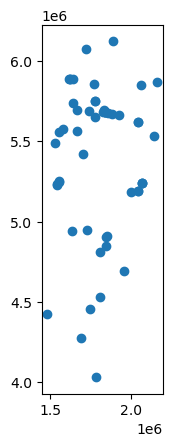

In [75]:
Argentina_museoBottomLeft.convex_hull.plot()

You **first need to dissolve**, and then you **create a hull**, an **envelope of  convex angles**:

<Axes: >

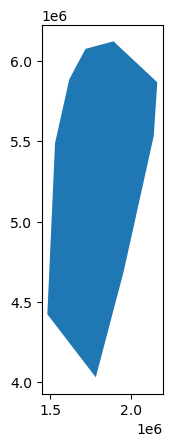

In [76]:
Argentina_museoBottomLeft.dissolve().convex_hull.plot()

As we saw, the **convex hull is a polygon**: 

In [77]:
Argentina_museoBottomLeft.dissolve().convex_hull

0    POLYGON ((1783082.565 4031075.811, 1481801.597...
dtype: geometry

We **can make hulls from any spatial object**:

<Axes: >

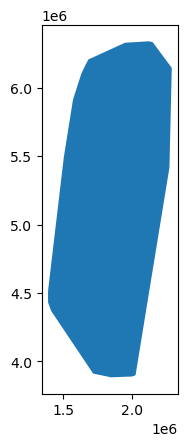

In [110]:
# SW of Brazil as convex hull
Argentina_bottomLeft.convex_hull.plot()

In this last case, what if we the **polygons had not been previously combined**?

<Axes: >

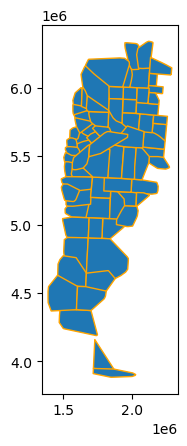

In [111]:
argentina_municipalities.cx[:centroidX,:centroidY].convex_hull.plot(edgecolor='orange')

That is, you get a **convex hull** for **each geometry**. 

We can also use **_union_ before** creating a **convex hull**:

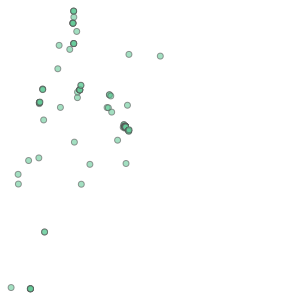

In [78]:
# just the union
museos_nacional=museos[museos.jurisdiccion=='Nacional']
museos_nacional.unary_union

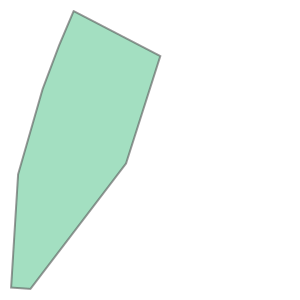

In [79]:
# hull of the union
museos_nacional.unary_union.convex_hull

Let's turn the **GS into a GDF**:

In [81]:
museos_nacional_hull= gpd.GeoDataFrame(index=[0],
                                    crs=museos_nacional.crs,
                                    geometry=[museos_nacional.unary_union.convex_hull])
museos_nacional_hull['name']='museos nacionales hull' # optional
#por qué se le pone index [0]
# then

museos_nacional_hull

geometry                    name
0  POLYGON ((1691730.796 4275392.212, 1476819.090...  museos nacionales hull

Let's use the **GDF in plotting**:

<Axes: >

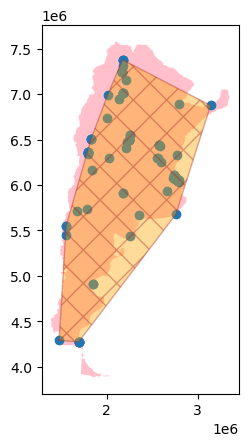

In [82]:
base=argentina.plot(facecolor='pink')
museos_nacional.plot(ax=base)
museos_nacional_hull.plot(ax=base,facecolor='orange',
                       edgecolor='brown',alpha=0.4,
                       hatch='X')
#como aptrapo en una geomtria ese es el convex hull, basicamente para un conjunto de coordendas encontrar lo que le envulve
#no puede dejar a nadie a fuera inclye a los que no son convex hull
#ls importancia es que nos ayuda a visulizar en donde estan la maypr cantidad e aeropuertos 

### Exercise 5 

<div class="alert-success">

1. Select some points from your maps.
    
2. Create the convex hull for those points.
    
3. Turn the hull into a GDF.
    
4. Plot the hull on top of the country.
    
</div>

## Spatial Overlay

We might need to create or find some geometries from the geometries we already have. Using a set theory approach, we will se the use of _intersection_, _union_, _difference_, and _symmetric difference_.

**Let me create this GeoDFs**:

In [85]:
# the north
MunisN_argentina=argentina_municipalities.cx[:,centroidY:]
# the south
MunisS_argentina=argentina_municipalities.cx[:,:centroidY]
# the west
MunisW_argentina=argentina_municipalities.cx[:centroidX,:]
# the east
MunisE_argentina=argentina_municipalities.cx[centroidX:,:]

### Intersection

We keep what is common in both GeoDFs:

In [86]:
munisMidNS_argentina=MunisN_argentina.overlay(MunisS_argentina, how="intersection",keep_geom_type=True)
munisMidNS_argentina

ADM0_ES_1 ADM0_PCODE_1     ADM1_ES_1 ADM1_PCODE_1              ADM2_ES_1  \
0   Argentina           AR  Buenos Aires        AR006          General Pinto   
1   Argentina           AR  Buenos Aires        AR006        Leandro N. Alem   
2   Argentina           AR  Buenos Aires        AR006       General Villegas   
3   Argentina           AR       Mendoza        AR050             San Rafael   
4   Argentina           AR  Buenos Aires        AR006                  Rojas   
5   Argentina           AR  Buenos Aires        AR006              Arrecifes   
6   Argentina           AR  Buenos Aires        AR006                  Salto   
7   Argentina           AR      San Luis        AR074             La Capital   
8   Argentina           AR      San Luis        AR074       Gobernador Dupuy   
9   Argentina           AR       Mendoza        AR050         General Alvear   
10  Argentina           AR      San Luis        AR074      General Pedernera   
11  Argentina           AR       Córdoba        AR014           General Roca   
12  Argentina           AR      San Luis        AR074       Gobernador Dupuy   
13  Argentina           AR  Buenos Aires        AR006   San Antonio de Areco   
14  Argentina           AR  Buenos Aires        AR006        Carmen de Areco   
15  Argentina           AR  Buenos Aires        AR006  Exaltación de la Cruz   
16  Argentina           AR  Buenos Aires        AR006      Capitán Sarmiento   
17  Argentina           AR  Buenos Aires        AR006                 Zárate   
18  Argentina           AR  Buenos Aires        AR006           San Fernando   
19  Argentina           AR  Buenos Aires        AR006                Campana   
20  Argentina           AR  Buenos Aires        AR006       General Arenales   
21  Argentina           AR  Buenos Aires        AR006                  Junín   
22  Argentina           AR       Mendoza        AR050               Malargüe   

               ADM2_REF_1 ADM2_PCODE_1  ADM0_ES_2 ADM0_PCODE_2     ADM1_ES_2  \
0           General Pinto     AR006351  Argentina           AR  Buenos Aires   
1         Leandro N. Alem     AR006462  Argentina           AR  Buenos Aires   
2        General Villegas     AR006392  Argentina           AR  Buenos Aires   
3              San Rafael     AR050105  Argentina           AR       Mendoza   
4                   Rojas     AR006686  Argentina           AR  Buenos Aires   
5               Arrecifes     AR006077  Argentina           AR  Buenos Aires   
6                   Salto     AR006714  Argentina           AR  Buenos Aires   
7              La Capital     AR074056  Argentina           AR      San Luis   
8        Gobernador Dupuy     AR074042  Argentina           AR      San Luis   
9          General Alvear     AR050014  Argentina           AR       Mendoza   
10      General Pedernera     AR074035  Argentina           AR      San Luis   
11           General Roca     AR014035  Argentina           AR       Córdoba   
12       Gobernador Dupuy     AR074042  Argentina           AR      La Pampa   
13   San Antonio de Areco     AR006735  Argentina           AR  Buenos Aires   
14        Carmen de Areco     AR006161  Argentina           AR  Buenos Aires   
15  Exaltacion de la Cruz     AR006266  Argentina           AR  Buenos Aires   
16      Capitan Sarmiento     AR006140  Argentina           AR  Buenos Aires   
17                 Zarate     AR006882  Argentina           AR  Buenos Aires   
18           San Fernando     AR006749  Argentina           AR  Buenos Aires   
19                Campana     AR006126  Argentina           AR  Buenos Aires   
20       General Arenales     AR006294  Argentina           AR  Buenos Aires   
21                  Junin     AR006413  Argentina           AR  Buenos Aires   
22               Malargue     AR050077  Argentina           AR       Mendoza   

   ADM1_PCODE_2              ADM2_ES_2             ADM2_REF_2 ADM2_PCODE_2  \
0         AR006          General Pinto          General Pinto     AR006351   
1     

This is similar to a **_spatial join_**:

In [87]:
MunisN_argentina.sjoin(MunisS_argentina, how="inner", predicate='contains')

ADM0_ES_left ADM0_PCODE_left  ADM1_ES_left ADM1_PCODE_left  \
4      Argentina              AR  Buenos Aires           AR006   
30     Argentina              AR      San Luis           AR074   
37     Argentina              AR  Buenos Aires           AR006   
57     Argentina              AR  Buenos Aires           AR006   
125    Argentina              AR  Buenos Aires           AR006   
141    Argentina              AR  Buenos Aires           AR006   
158    Argentina              AR  Buenos Aires           AR006   
190    Argentina              AR      San Luis           AR074   
228    Argentina              AR  Buenos Aires           AR006   
240    Argentina              AR       Mendoza           AR050   
244    Argentina              AR       Mendoza           AR050   
284    Argentina              AR  Buenos Aires           AR006   
315    Argentina              AR       Mendoza           AR050   
341    Argentina              AR  Buenos Aires           AR006   
367    Argentina              AR      San Luis           AR074   
378    Argentina              AR  Buenos Aires           AR006   
384    Argentina              AR       Córdoba           AR014   
415    Argentina              AR  Buenos Aires           AR006   
416    Argentina              AR  Buenos Aires           AR006   
494    Argentina              AR  Buenos Aires           AR006   
504    Argentina              AR  Buenos Aires           AR006   
525    Argentina              AR  Buenos Aires           AR006   

              ADM2_ES_left          ADM2_REF_left ADM2_PCODE_left  \
4            General Pinto          General Pinto        AR006351   
30        Gobernador Dupuy       Gobernador Dupuy        AR074042   
37    San Antonio de Areco   San Antonio de Areco        AR006735   
57                   Rojas                  Rojas        AR006686   
125        Carmen de Areco        Carmen de Areco        AR006161   
141       General Arenales       General Arenales        AR006294   
158              Arrecifes              Arrecifes        AR006077   
190             La Capital             La Capital        AR074056   
228           San Fernando           San Fernando        AR006749   
240         General Alvear         General Alvear        AR050014   
244               Malargüe               Malargue        AR050077   
284        Leandro N. Alem        Leandro N. Alem        AR006462   
315             San Rafael             San Rafael        AR050105   
341  Exaltación de la Cruz  Exaltacion de la Cruz        AR006266   
367      General Pedernera      General Pedernera        AR074035   
378                  Junín                  Junin        AR006413   
384           General Roca           General Roca        AR014035   
415                Campana                Campana        AR006126   
416       General Villegas       General Villegas        AR006392   
494      Capitán Sarmiento      Capitan Sarmiento        AR006140   
504                 Zárate                 Zarate        AR006882   
525                  Salto                  Salto        AR006714   

                                              geometry  index_right  \
4    POLYGON Z ((2421316.725 6134973.446 0.000, 243...            4   
30   POLYGON Z ((2131370.565 6142762.326 0.000, 213...           30   
37   POLYGON Z ((2674911.340 6165337.318 0.000, 267...           37   
57   POLYGON Z ((2537409.340 6186011.722 0.000, 253...           57   
125  POLYGON Z ((2631524.583 6142783.347 0.000, 263...          125   
141  POLYGON Z ((2489705.595 6180887.889 0.000, 249...          141   
158  POLYGON Z ((2602745.233 6197389.003 0.000, 260...          158   
190  POLYGON Z ((1965607.211 6326537.210 0.000, 196...          190   
228  MULTIPOLYGON Z (((2758179.827 6153566.452 0.00...          228   
240  POLYGON Z ((1976792.576 6171691.654 0.000, 197...          240   
244  POLYGON Z ((1662461.766 6160499.265 0.000, 166...          244   
284  POLYGON Z ((2464029.169 6154793.295 0.00

<Axes: >

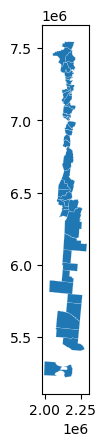

In [88]:
# keeping the overlay
munisMidWE_argentina=MunisW_argentina.overlay(MunisE_argentina, how="intersection",keep_geom_type=True)
munisMidWE_argentina.plot(edgecolor='white',linewidth=0.1)

### Union

Let me unite the previous two GeoDFs. First, take a look at each one:

In [89]:
munisMidNS_argentina.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ADM0_ES_1     23 non-null     object  
 1   ADM0_PCODE_1  23 non-null     object  
 2   ADM1_ES_1     23 non-null     object  
 3   ADM1_PCODE_1  23 non-null     object  
 4   ADM2_ES_1     23 non-null     object  
 5   ADM2_REF_1    23 non-null     object  
 6   ADM2_PCODE_1  23 non-null     object  
 7   ADM0_ES_2     23 non-null     object  
 8   ADM0_PCODE_2  23 non-null     object  
 9   ADM1_ES_2     23 non-null     object  
 10  ADM1_PCODE_2  23 non-null     object  
 11  ADM2_ES_2     23 non-null     object  
 12  ADM2_REF_2    23 non-null     object  
 13  ADM2_PCODE_2  23 non-null     object  
 14  geometry      23 non-null     geometry
dtypes: geometry(1), object(14)
memory usage: 2.8+ KB


In [90]:
munisMidWE_argentina.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ADM0_ES_1     45 non-null     object  
 1   ADM0_PCODE_1  45 non-null     object  
 2   ADM1_ES_1     45 non-null     object  
 3   ADM1_PCODE_1  45 non-null     object  
 4   ADM2_ES_1     45 non-null     object  
 5   ADM2_REF_1    45 non-null     object  
 6   ADM2_PCODE_1  45 non-null     object  
 7   ADM0_ES_2     45 non-null     object  
 8   ADM0_PCODE_2  45 non-null     object  
 9   ADM1_ES_2     45 non-null     object  
 10  ADM1_PCODE_2  45 non-null     object  
 11  ADM2_ES_2     45 non-null     object  
 12  ADM2_REF_2    45 non-null     object  
 13  ADM2_PCODE_2  45 non-null     object  
 14  geometry      45 non-null     geometry
dtypes: geometry(1), object(14)
memory usage: 5.4+ KB


The **overlay combines the geometries**, but **not** the **attributes**. **Let me subset and show you**:

In [91]:
keep=['ADM0_ES_1','ADM1_ES_1','ADM2_ES_1','geometry']
munisMidNS_argentina=munisMidNS_argentina.loc[:,keep]
munisMidWE_argentina=munisMidWE_argentina.loc[:,keep]


In [92]:
# now 
munisMidNS_argentina.overlay(munisMidWE_argentina,how="union",keep_geom_type=True)
#creo otracolumna ha duplicado pero el union solo trabaja con geometrias

ADM0_ES_1_1   ADM1_ES_1_1       ADM2_ES_1_1 ADM0_ES_1_2 ADM1_ES_1_2  \
0    Argentina       Córdoba      General Roca   Argentina     Córdoba   
1    Argentina  Buenos Aires     General Pinto         NaN         NaN   
2    Argentina  Buenos Aires   Leandro N. Alem         NaN         NaN   
3    Argentina  Buenos Aires  General Villegas         NaN         NaN   
4    Argentina       Mendoza        San Rafael         NaN         NaN   
..         ...           ...               ...         ...         ...   
62         NaN           NaN               NaN   Argentina     Tucumán   
63         NaN           NaN               NaN   Argentina     Tucumán   
64         NaN           NaN               NaN   Argentina       Salta   
65         NaN           NaN               NaN   Argentina     Tucumán   
66         NaN           NaN               NaN   Argentina       Jujuy   

      ADM2_ES_1_2                                           geometry  
0    General Roca  POLYGON Z ((2137474.958 6221703.567 0.000, 213...  
1             NaN  POLYGON Z ((2432806.820 6120338.130 0.000, 244...  
2             NaN  POLYGON Z ((2467305.043 6150755.672 0.000, 247...  
3             NaN  POLYGON Z ((2389318.632 6132402.140 0.000, 238...  
4             NaN  POLYGON Z ((1946315.712 6195039.159 0.000, 197...  
..            ...                                                ...  
62        Trancas  POLYGON Z ((2165498.999 7101539.224 0.000, 216...  
63         Leales  POLYGON Z ((2167201.153 7004641.461 0.000, 216...  
64  La Candelaria  POLYGON Z ((2173252.299 7123203.718 0.000, 217...  
65    Yerba Buena  POLYGON Z ((2154819.403 7029883.139 0.000, 215...  
66           Yaví  POLYGON Z ((2140580.380 7546712.579 0.000, 214...  

[67 rows x 7 columns]

As you see, geometries are fine, but not attributes. It is strictly NOT appending the GeoDFs:

In [93]:
# appending
pd.concat([munisMidNS_argentina,munisMidWE_argentina],ignore_index=True)

ADM0_ES_1     ADM1_ES_1         ADM2_ES_1  \
0   Argentina  Buenos Aires     General Pinto   
1   Argentina  Buenos Aires   Leandro N. Alem   
2   Argentina  Buenos Aires  General Villegas   
3   Argentina       Mendoza        San Rafael   
4   Argentina  Buenos Aires             Rojas   
..        ...           ...               ...   
63  Argentina       Tucumán           Trancas   
64  Argentina       Tucumán            Leales   
65  Argentina         Salta     La Candelaria   
66  Argentina       Tucumán       Yerba Buena   
67  Argentina         Jujuy              Yaví   

                                             geometry  
0   POLYGON Z ((2432806.820 6120338.130 0.000, 244...  
1   POLYGON Z ((2467305.043 6150755.672 0.000, 247...  
2   POLYGON Z ((2390171.334 6132299.863 0.000, 238...  
3   POLYGON Z ((1946315.712 6195039.159 0.000, 197...  
4   POLYGON Z ((2537973.859 6186507.051 0.000, 254...  
..                                                ...  
63  POLYGON Z ((2165498.999 7101539.224 0.000, 216...  
64  POLYGON Z ((2167201.153 7004641.461 0.000, 216...  
65  POLYGON Z ((2173252.299 7123203.718 0.000, 217...  
66  POLYGON Z ((2154819.403 7029883.139 0.000, 215...  
67  POLYGON Z ((2140580.380 7546712.579 0.000, 214...  

[68 rows x 4 columns]

**You will append if** you are **interested in the keeping the attributes**. But you **just do the overlay if** you are **planing to combine final results**:

<Axes: >

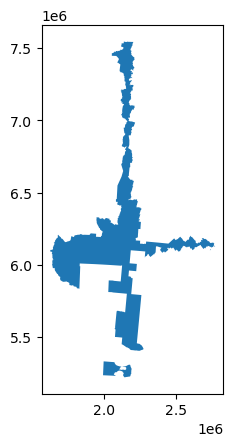

In [94]:
munisMidNS_argentina.dissolve().overlay(munisMidWE_argentina.dissolve(), how="union",keep_geom_type=True).dissolve().plot()

**Let me create an object to save the previous result**:

In [102]:
muniMidArgentina=munisMidNS_argentina.dissolve().overlay(munisMidWE_argentina.dissolve(), how="union",keep_geom_type=True).dissolve()
muniMidArgentina

geometry ADM0_ES_1_1  \
0  MULTIPOLYGON Z (((2116097.038 5276673.150 0.00...   Argentina   

    ADM1_ES_1_1    ADM2_ES_1_1 ADM0_ES_1_2 ADM1_ES_1_2 ADM2_ES_1_2  
0  Buenos Aires  General Pinto   Argentina     Córdoba       Pocho

In [103]:
# some cleaning

muniMidArgentina['zone']='middles'
muniMidArgentina=muniMidArgentina.loc[:,['ADM0_ES_1_1','zone','geometry']]   
muniMidArgentina

ADM0_ES_1_1     zone                                           geometry
0   Argentina  middles  MULTIPOLYGON Z (((2116097.038 5276673.150 0.00...

### Difference

Here, you **keep what belongs to the GeoDF** to left that **is not in the GeoDF to the right**:

<Axes: >

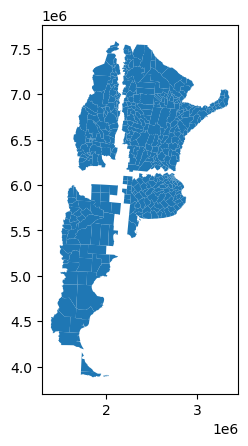

In [104]:
# with the municipalities
argentina_municipalities.overlay(muniMidArgentina, how='difference').plot()

<Axes: >

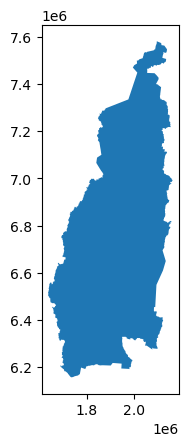

In [105]:
# with the zones
Argentina_topLeft.overlay(muniMidArgentina, how='difference').plot()

### Symmetric Difference

This is the opposite to *intersection*, you keep what is not in the intersection:

<Axes: >

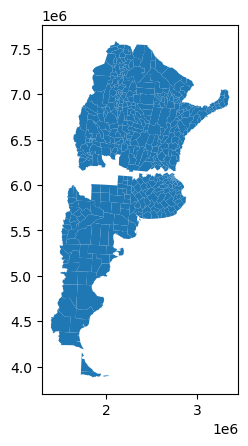

In [106]:
MunisN_argentina.overlay(MunisS_argentina, how="symmetric_difference",keep_geom_type=False).plot()

<Axes: >

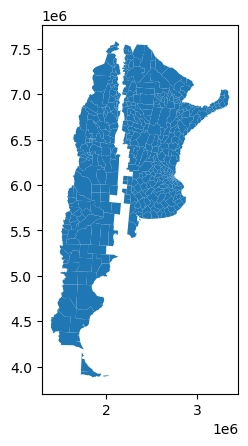

In [107]:
MunisW_argentina.overlay(MunisE_argentina, how="symmetric_difference",keep_geom_type=False).plot()

### Exercise 6 

<div class="alert-success">

1. Apply two of these operations to your maps.
2. Apply two of these operations to the  next maps:
        
</div>

In [108]:
# hulls para los museos municipales:
Argentina_museoTopLeft_hull=Argentina_museoTopLeft.dissolve().convex_hull
Argentina_museoTopRight_hull=Argentina_museoTopRight.dissolve().convex_hull
Argentina_museoBottomLeft_hull=Argentina_museoBottomLeft.dissolve().convex_hull
Argentina_museoBottomRight_hull=Argentina_museoBottomRight.dissolve().convex_hull

<Axes: >

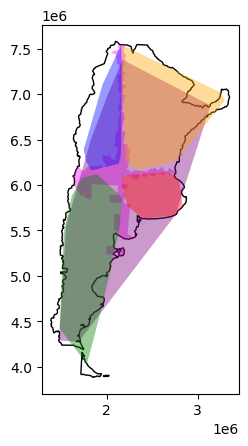

In [109]:
base = argentina.plot(color='white', edgecolor='black') #unprojected
muniMidArgentina.plot(ax=base,facecolor='magenta',alpha=0.4) #unprojected
museos_nacional_hull.plot(ax=base,facecolor='purple',alpha=0.4)
Argentina_museoTopLeft_hull.plot(ax=base,facecolor='blue', alpha=0.4)
Argentina_museoTopRight_hull.plot(ax=base,facecolor='orange', alpha=0.4)
Argentina_museoBottomLeft_hull.plot(ax=base,facecolor='green', alpha=0.4)
Argentina_museoBottomRight_hull.plot(ax=base,facecolor='red', alpha=0.4)

In [ ]:
#convirtiendo a gdf

In [119]:
Argentina_museoTopLeft_hull= gpd.GeoDataFrame(index=[0],
                                    crs=museos_nacional.crs,
                                    geometry=[Argentina_museoTopLeft.unary_union.convex_hull])

Argentina_museoTopRight_hull= gpd.GeoDataFrame(index=[0],
                                    crs=museos_nacional.crs,
                                    geometry=[Argentina_museoTopRight.unary_union.convex_hull])

Argentina_museoBottomLeft_hull= gpd.GeoDataFrame(index=[0],
                                    crs=museos_nacional.crs,
                                    geometry=[museos.unary_union.convex_hull])

Argentina_museoBottomRight_hull= gpd.GeoDataFrame(index=[0],
                                    crs=museos_nacional.crs,
                                    geometry=[museos.unary_union.convex_hull])

In [120]:
#muniMidArgentina=munisMidNS_argentina.dissolve().overlay(munisMidWE_argentina.dissolve(), how="union",keep_geom_type=True).dissolve()
#muniMidArgentina

C:\Users\Edgar Ramos Castro\AppData\Local\Temp\ipykernel_13788\3190076435.py:1: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  Argentina_museoTopLeft_hull.overlay(Argentina_museoTopRight_hull, how='difference').plot()


<Axes: >

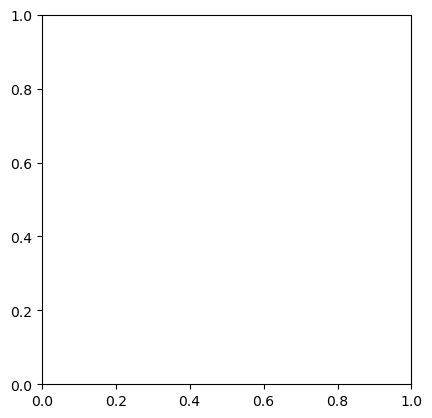

In [121]:
Argentina_museoTopLeft_hull.overlay(Argentina_museoTopRight_hull, how='difference').plot()

In [ ]:
Argentina_museoTopLeft_hull.overlay(Argentina_museoTopRight_hull, how='union').plot()

<a class="anchor" id="4"></a>

## Validity of Geometry

Geometries are created in a way that **some issues may appear, especially in (multi) polygons**.
Let's check if our recent maps on states and municipalities are valid:

In [142]:
# non valid
argentina_municipalities[~argentina_municipalities.is_valid]

Empty GeoDataFrame
Columns: [ADM0_ES, ADM0_PCODE, ADM1_ES, ADM1_PCODE, ADM2_ES, ADM2_REF, ADM2_PCODE, geometry]
Index: []

C:\Users\Edgar Ramos Castro\AppData\Local\Temp\ipykernel_18388\1367255169.py:2: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  argentina_municipalities[~argentina_municipalities.is_valid].plot()


<Axes: >

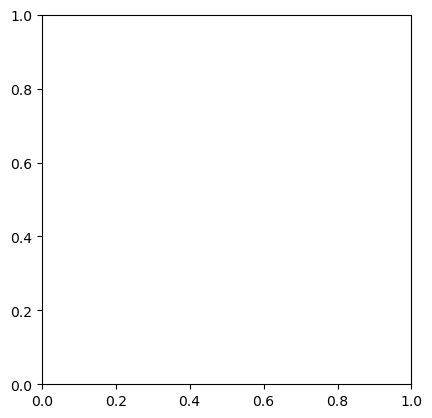

In [140]:
# see the invalid:
argentina_municipalities[~argentina_municipalities.is_valid].plot()

It is difficult to see what is wrong. Let's get some information:

In [144]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(argentina_municipalities[~argentina_municipalities.is_valid].geometry)

GeoSeries([], Name: geometry, dtype: geometry)

In [145]:
# varieties?
argentina_municipalities['validity']=[x.split('[')[0] for x in argentina_municipalities.geometry.apply(lambda x: explain_validity(x))]
argentina_municipalities['validity'].value_counts()

validity
Valid Geometry    526
Name: count, dtype: int64

In [146]:
# solving the issue:
argentina_municipalities.drop(columns=['validity'],inplace=True)

argentina_municipalities_valid=argentina_municipalities.copy()

argentina_municipalities_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in argentina_municipalities_valid['geometry'] ]
#any invalid?
argentina_municipalities_valid[~argentina_municipalities_valid.is_valid]

Empty GeoDataFrame
Columns: [ADM0_ES, ADM0_PCODE, ADM1_ES, ADM1_PCODE, ADM2_ES, ADM2_REF, ADM2_PCODE, geometry]
Index: []

The _solution_ we got may help for some advanced techniques, but may also give us some extra trouble. Notice that once geopandas solved the problem, you  have created **collections**:

In [147]:
[x for x in argentina_municipalities_valid["geometry"]]

[<POLYGON Z ((2035707.2 6832436.727 0, 2035605.859 6832395 0, 2036129.206 683...>,
 <POLYGON Z ((2538302.326 5707868.076 0, 2548468.223 5694957.381 0, 2563522.4...>,
 <POLYGON Z ((2184906.173 7295226.281 0, 2184974.835 7295217.027 0, 2185012.2...>,
 <POLYGON Z ((2844051.406 5776077.259 0, 2844047.686 5776071.926 0, 2842927.6...>,
 <POLYGON Z ((2421316.725 6134973.446 0, 2432806.82 6120338.13 0, 2440486.988...>,
 <POLYGON Z ((3241229.01 6956163.04 0, 3241759.11 6955606.783 0, 3241760.374 ...>,
 <POLYGON Z ((2832421.028 5818823.014 0, 2832690.945 5818464.112 0, 2833870.8...>,
 <POLYGON Z ((1899146.694 6291175.015 0, 1898081.171 6255371.192 0, 1917056.0...>,
 <POLYGON Z ((2633773.481 5749288.737 0, 2633787.329 5749232.091 0, 2633833.6...>,
 <POLYGON Z ((2784714.361 5838873.468 0, 2781933.346 5836650.835 0, 2779880.1...>,
 <POLYGON Z ((2541175.711 6232351.983 0, 2541211.766 6232321.14 0, 2541261.85...>,
 <POLYGON Z ((2714843.822 6108280.539 0, 2715201.431 6107800.236 0, 2715357.7...>,
 <PO

In [148]:
pd.Series([type(x) for x in argentina_municipalities_valid.geometry]).value_counts()

<class 'shapely.geometry.polygon.Polygon'>              507
<class 'shapely.geometry.multipolygon.MultiPolygon'>     19
Name: count, dtype: int64

In [105]:
# brazil.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='country', driver="GPKG")
# brazil_cities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='cities', driver="GPKG")
# brazil_rivers.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='rivers', driver="GPKG")
# airports.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='airports', driver="GPKG")
# brazil_border.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='border', driver="GPKG")
# brazil_states.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='states', driver="GPKG")
# brazil_municipalities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='municipalities', driver="GPKG")